In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import math
import glob
import time
from datetime import date
from typing import Tuple, Union

import numpy as np
import pandas as pd
import pydicom
from tqdm import tqdm_notebook as tqdm
import cv2
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as K

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit


2024-12-17 10:52:35.395603: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734432755.417060  179828 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734432755.423617  179828 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
#--------------------- for working with directory ----------------------------
ROOT_DATA_PATH='/workspace/datasets'
DATASET_PATH=f'{ROOT_DATA_PATH}/rsna-intracranial-hemorrhage-detection'

TRAIN_DATA_PATH=f'{DATASET_PATH}/stage_2_train'
TRAIN_SINOGRAM_DATA_PATH=f'{DATASET_PATH}/stage_2_train_sinogram'
TRAIN_METADATA_PATH=f'{DATASET_PATH}/processed_metadata/train_metadata_df.pkl'

SEED = 666

In [4]:
IMG_SIZE = (360, 362)
IMG_SHAPE = (*IMG_SIZE, 3)

In [5]:
#seeding
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [6]:
def read_sinogram(fpath):
    im = None
    try:
        im = np.load(fpath).astype(np.float32)
    except Exception as e:
        print('\nWarning:', e.__class__.__name__, f'for {fpath} Replacing with zeros sinogram values')
        im = np.zeros(IMG_SHAPE, dtype=np.float32)
    return im

In [7]:
class TrainSinoDataGenerator(keras.utils.Sequence):
    def __init__(self, img_ids, labels, img_dir, img_shape, num_classes, batch_size, under_sampling=False, shuffle_on_epoch_end=True, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.img_ids = img_ids
        self.labels = labels
        self.img_dir = img_dir
        self.img_shape = img_shape
        self.num_classes = num_classes
        self.batch_size = batch_size
        self.under_sampling = under_sampling
        self.shuffle_on_epoch_end = shuffle_on_epoch_end
        self.on_epoch_end()
    
    def __len__(self):
        return math.ceil(len(self.img_ids) / self.batch_size)

    def __getitem__(self, index):
        low = index*self.batch_size
        high = min(low + self.batch_size, len(self.img_ids))
        indices = self.indices[low:high]
        X,y = self.__data_generation(indices)

        return X,y
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.img_ids))
        
        if self.under_sampling:
            keep_prob = self.labels.iloc[:,0].map({0: 0.35, 1: 0.5})
            keep = (keep_prob > np.random.rand(len(keep_prob)))
            self.indices = self.indices[keep]
            
        if self.shuffle_on_epoch_end:
            np.random.shuffle(self.indices)

        
    def __data_generation(self, indices):
        X = np.empty((self.batch_size, *self.img_shape))
        y = np.empty((self.batch_size, self.num_classes), dtype=np.float32)
        
        for i, img_idx in enumerate(indices):
            img_id = self.img_ids[img_idx]
            img_path = f'{self.img_dir}/{img_id}.npy'
            img = read_sinogram(img_path)
            X[i,] = img
            y[i,] = self.labels.iloc[img_idx].values
            
        return X,y
         

In [8]:
df = pd.read_pickle(TRAIN_METADATA_PATH)
test_df_neg = df[df['Label']['any'] == 0].sample(n=200)
test_df_pos = df[df['Label']['any'] == 1].sample(n=200)
test_df = pd.concat([test_df_pos, test_df_neg]).sample(frac=1)
df = df.drop(test_df.index)
df

Label                                                          \
Diagnosis      any epidural intraparenchymal intraventricular subarachnoid   
Image                                                                        
ID_99196d0ab     1        0                0                0            0   
ID_2b0190b58     0        0                0                0            0   
ID_056e14224     1        1                0                0            0   
ID_525e72262     0        0                0                0            0   
ID_b00eddf10     0        0                0                0            0   
...            ...      ...              ...              ...          ...   
ID_21e825c20     0        0                0                0            0   
ID_85141c704     1        0                1                0            0   
ID_b4add57dd     0        0                0                0            0   
ID_02f0d7dbb     0        0                0                0            0   
ID_7d29263ce     1        0                0                0            0   

                       
Diagnosis    subdural  
Image                  
ID_99196d0ab        1  
ID_2b0190b58        0  
ID_056e14224        0  
ID_525e72262        0  
ID_b00eddf10        0  
...               ...  
ID_21e825c20        0  
ID_85141c704        1  
ID_b4add57dd        0  
ID_02f0d7dbb        0  
ID_7d29263ce        1  

[263606 rows x 6 columns]

In [9]:
df['Label']['any'].value_counts()

any
0    146510
1    117096
Name: count, dtype: int64

In [10]:
test_df['Label']['any'].value_counts()

any
1    200
0    200
Name: count, dtype: int64

In [ ]:
class SinoDeepModel():
    def __init__(self, base,input_shape, batch_size, num_epochs, num_classes, learning_rate, decay_rate, decay_steps, base_name='base_model', weights='imagenet', freeze_base=False, saving_path=None, verbose=1):
        self.base = base
        self.input_shape = input_shape
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.decay_rate = decay_rate
        self.decay_steps = decay_steps
        self.base_name = base_name
        self.weights = weights
        self.freeze_base = freeze_base
        self.saving_path = saving_path
        self.verbose = verbose
        self._build()
        self._create_saving_path_if_none()
    
    def _build(self):
        K.clear_session()
        base = self.base(include_top=False, weights=self.weights, pooling='avg', input_shape=self.input_shape)
        base.trainable = not self.freeze_base
            
        x = base.output
        x = layers.Dropout(0.2)(x)
        out = layers.Dense(self.num_classes, activation='sigmoid', name='dense_output')(x)
        
        self.model = keras.models.Model(inputs=base.input, outputs=out)
        
        
        self.model.compile(
            loss=keras.losses.BinaryCrossentropy(), 
            optimizer=keras.optimizers.Adam(learning_rate=self.learning_rate),
            metrics=[
                keras.metrics.TruePositives(name='tp'),
                keras.metrics.TrueNegatives(name='tn'),
                keras.metrics.FalsePositives(name='fp'),
                keras.metrics.FalseNegatives(name='fn'),
                keras.metrics.BinaryAccuracy(name='binary_acc'), 
                keras.metrics.Precision(name='precision'),
                keras.metrics.Recall(name='recall'),
                keras.metrics.AUC(name='auc_roc', curve='ROC', multi_label=True, num_labels=self.num_classes),
                keras.metrics.AUC(name='auc_pr', curve='PR', multi_label=True, num_labels=self.num_classes),
                keras.metrics.F1Score(name='f1_score', average='weighted'),                
            ]
        )
        
    def _create_saving_path_if_none(self):
        if self.saving_path is None:
            print('saving_path is None. Automatically create path for save training utilities')
            saving_path = os.path.join('saved_model', self.base.__name__)
            os.makedirs(saving_path, exist_ok=True)
            self.saving_path = saving_path
            print(self.saving_path, 'created for saving_path')
        
    def fit(self, train_df, valid_df):
        train_data_gen = TrainSinoDataGenerator(
            img_ids=train_df.index, 
            labels=train_df,
            img_dir=TRAIN_SINOGRAM_DATA_PATH,
            img_shape=self.input_shape,
            num_classes=self.num_classes,
            batch_size=self.batch_size,
            under_sampling=False,
            workers=128,
            use_multiprocessing=True
        )
        
        valid_data_gen = TrainSinoDataGenerator(
            img_ids=valid_df.index, 
            labels=valid_df,
            img_dir=TRAIN_SINOGRAM_DATA_PATH,
            img_shape=self.input_shape,
            num_classes=self.num_classes,
            batch_size=self.batch_size,
            under_sampling=False,
            workers=128,
            use_multiprocessing=True
        )
        
        curr_time = int(time.time())
        callbacks = [
            keras.callbacks.ModelCheckpoint(filepath='%s/{epoch:02d}-%s.weights.h5' % (self.saving_path, curr_time), monitor='val_loss', mode='min', verbose=self.verbose, save_weights_only=True, save_best_only=True),
            keras.callbacks.LearningRateScheduler(lambda epoch: self.learning_rate * pow(self.decay_rate, math.floor(epoch / self.decay_steps)), verbose=1),
            keras.callbacks.EarlyStopping(verbose=1, restore_best_weights=True, monitor='val_loss', patience=5, mode='min'),
            keras.callbacks.CSVLogger(filename='%s/%s.csv'%(self.saving_path, f'{curr_time}-train_log'))
        ]
        return self.model.fit(
            x=train_data_gen,
            validation_data=valid_data_gen,
            callbacks=callbacks,
            epochs=self.num_epochs,
            verbose=self.verbose
        )
    
    def save(self, filename, overwrite=True):
        _, ext = os.path.splitext(filename)
        if ext != '.keras':
          filename = f'{filename}.keras'
          
        p = os.path.join(self.saving_path, filename)
        self.model.save(p, overwrite=overwrite)
        print('model saved to:', p)
        
    def load_weights(self, path, *args, **kwargs):
        self.model.load_weights(path, *args, **kwargs)
        
    def load(self, path, *args, **kwargs):
        self.model = keras.models.load_model(path, *args, **kwargs)
        

In [12]:
EPOCH = 10
INPUT_SHAPE = IMG_SHAPE
BATCH_SIZE = 32
N_CLASSES = 6

In [13]:
saving_path = 'saved_model/EfficientNetB4_Sino'
os.makedirs(saving_path, exist_ok=True)
model = SinoDeepModel(
    base=keras.applications.EfficientNetB4,
    weights='imagenet',
    freeze_base=False,
    input_shape=INPUT_SHAPE, 
    batch_size=BATCH_SIZE, 
    num_epochs=EPOCH,
    num_classes=N_CLASSES,
    learning_rate=0.000125, 
    decay_rate=0.5, 
    decay_steps=1,
    saving_path=saving_path
)

I0000 00:00:1734432771.036454  179828 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8225 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 1g.10gb, pci bus id: 0000:07:00.0, compute capability: 8.0


In [14]:
msss = MultilabelStratifiedShuffleSplit(n_splits=EPOCH, test_size=0.15, random_state=SEED)
X = df.index
Y = df['Label'].values

msss_splits = next(msss.split(X, Y))
train_idx = msss_splits[0]
valid_idx = msss_splits[1]

In [ ]:
np.random.shuffle(train_idx)

model.fit(df.iloc[train_idx], df.iloc[valid_idx])

In [17]:
# model.save('final_efficientnetb4_sino.keras')
model.load('/workspace/saved_model/EfficientNetB4_Sino/final_efficientnetb4_sino.keras')

In [19]:
hist_path = '/workspace/saved_model/EfficientNetB4_Sino/1734357960-train_log.csv'
train_history = pd.read_csv(hist_path)

In [20]:
train_history

epoch    auc_pr   auc_roc  binary_acc  \
0      1  0.778483  0.923127    0.897750   
1      2  0.881729  0.962510    0.928154   
2      3  0.928340  0.978753    0.946016   
3      4  0.954498  0.986951    0.958389   
4      5  0.967095  0.990823    0.965633   
5      6  0.972991  0.992483    0.969186   
6      7  0.975653  0.993268    0.971074   
7      8  0.977162  0.993731    0.971958   
8      9  0.977454  0.993704    0.972407   
9     10  0.977722  0.993883    0.972400   

                                            f1_score        fn       fp  \
0  "[tf.Tensor(0.6275499, shape=(), dtype=float32...  100224.0  37256.0   
1  "[tf.Tensor(0.6159185, shape=(), dtype=float32...   66090.0  30511.0   
2  "[tf.Tensor(0.63629633, shape=(), dtype=float3...   47512.0  25074.0   
3  "[tf.Tensor(0.66892076, shape=(), dtype=float3...   35772.0  20177.0   
4  "[tf.Tensor(0.7014014, shape=(), dtype=float32...   29118.0  17092.0   
5  "[tf.Tensor(0.71737784, shape=(), dtype=float3...   25953.0  15478.0   
6  "[tf.Tensor(0.71968096, shape=(), dtype=float3...   24265.0  14626.0   
7  "[tf.Tensor(0.7263834, shape=(), dtype=float32...   23356.0  14349.0   
8  "[tf.Tensor(0.7289322, shape=(), dtype=float32...   22950.0  14151.0   
9  "[tf.Tensor(0.7279451, shape=(), dtype=float32...   23076.0  14035.0   

   learning_rate      loss  precision  ...  val_auc_roc  val_binary_acc  \
0   1.250000e-04  0.247054   0.788068  ...     0.629725        0.822601   
1   6.250000e-05  0.174164   0.849946  ...     0.582964        0.822297   
2   3.125000e-05  0.134220   0.884082  ...     0.879352        0.883799   
3   1.562500e-05  0.105332   0.909586  ...     0.920239        0.905929   
4   7.812500e-06  0.088443   0.924616  ...     0.910277        0.897514   
5   3.906250e-06  0.079685   0.932198  ...     0.961358        0.934327   
6   1.953125e-06  0.075380   0.936167  ...     0.962003        0.933426   
7   9.765625e-07  0.072901   0.937544  ...     0.965716        0.938950   
8   4.882813e-07  0.072349   0.938466  ...     0.965519        0.939641   
9   2.441406e-07  0.071878   0.938904  ...     0.966057        0.939657   

                                        val_f1_score   val_fn  val_fp  \
0  "[tf.Tensor(0.5837124, shape=(), dtype=float32...  42095.0     4.0   
1  "[tf.Tensor(0.504435, shape=(), dtype=float32)...  42166.0     5.0   
2  "[tf.Tensor(0.69352853, shape=(), dtype=float3...  23127.0  4449.0   
3  "[tf.Tensor(0.70289546, shape=(), dtype=float3...  17057.0  5267.0   
4  "[tf.Tensor(0.7249421, shape=(), dtype=float32...  15663.0  8658.0   
5  "[tf.Tensor(0.7117519, shape=(), dtype=float32...   9336.0  6249.0   
6  "[tf.Tensor(0.723439, shape=(), dtype=float32)...   8647.0  7152.0   
7  "[tf.Tensor(0.7277494, shape=(), dtype=float32...   8377.0  6111.0   
8  "[tf.Tensor(0.7232771, shape=(), dtype=float32...   8386.0  5938.0   
9  "[tf.Tensor(0.72352993, shape=(), dtype=float3...   8225.0  6095.0   

   val_loss val_precision  val_recall    val_tn   val_tp  
0  1.168819      0.961165    0.002346  195114.0     99.0  
1  1.234129      0.864865    0.000758  195109.0     32.0  
2  0.382581      0.810818    0.451902  190668.0  19068.0  
3  0.287130      0.826789    0.595787  189847.0  25141.0  
4  0.319525      0.753971    0.628804  186458.0  26533.0  
5  0.189986      0.840244    0.778784  188860.0  32867.0  
6  0.192260      0.824297    0.795095  187960.0  33553.0  
7  0.179622      0.846984    0.801507  188998.0  33826.0  
8  0.179839      0.850650    0.801313  189167.0  33821.0  
9  0.178622      0.847895    0.805099  189016.0  33976.0  

[10 rows x 24 columns]

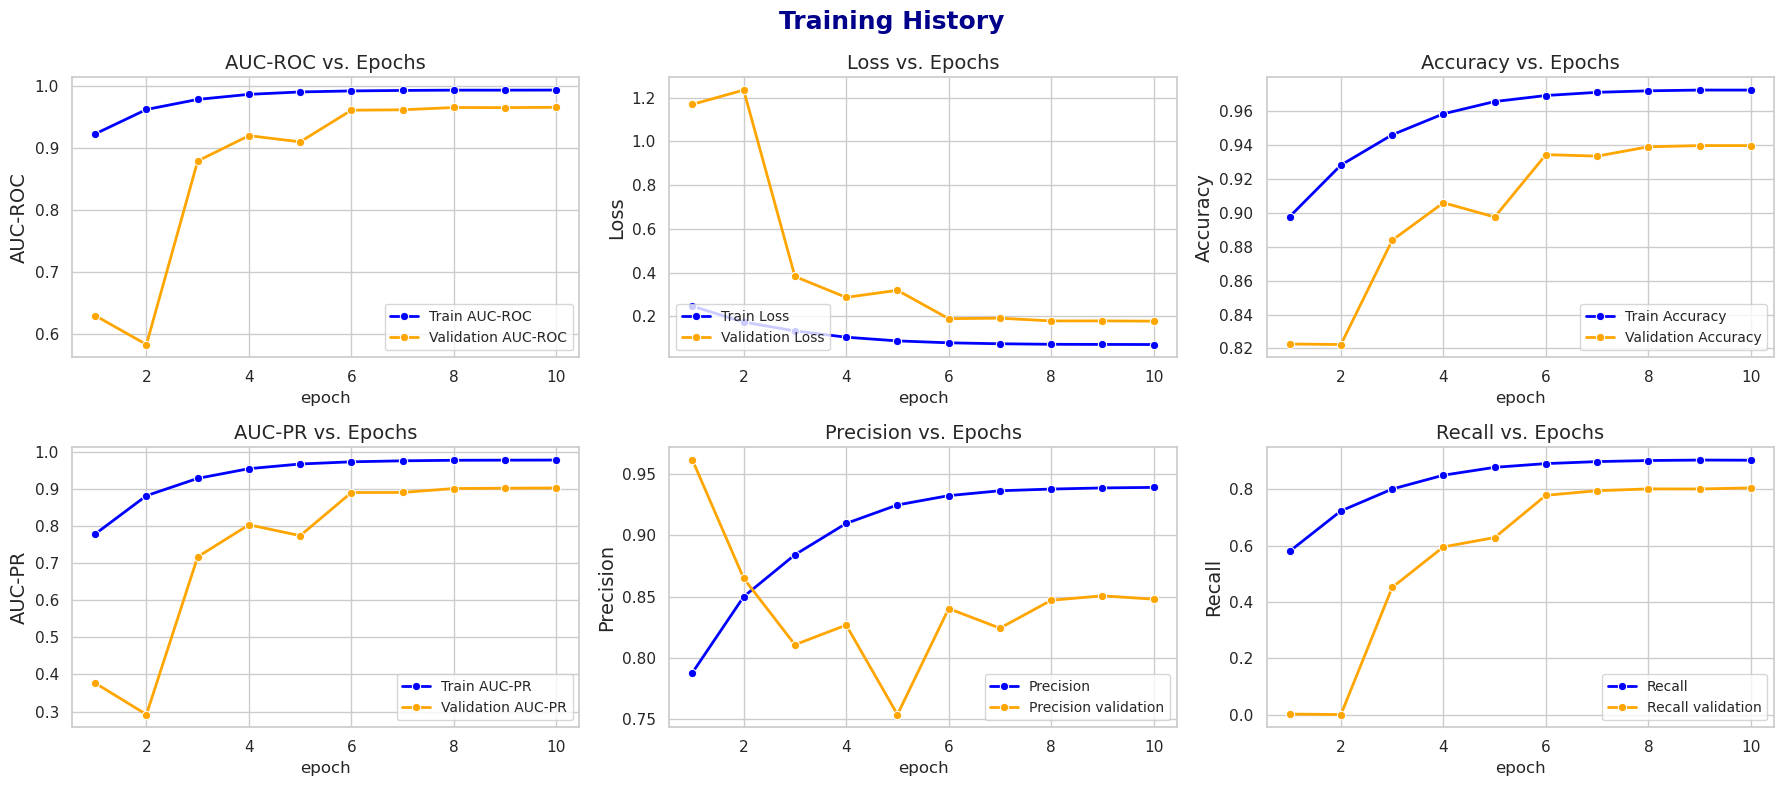

In [21]:

# Set seaborn theme
sns.set_theme(style="whitegrid")

# Create the figure and axes
fig, axes = plt.subplots(2, 3, figsize=(18, 8), sharey=False)
fig.suptitle("Training History", fontsize=18, fontweight="bold", color="darkblue")

# 1st subplot: AUC-ROC
sns.lineplot(data=train_history, x='epoch', y='auc_roc', label='Train AUC-ROC', ax=axes[0, 0], color='blue', linewidth=2, marker='o')
sns.lineplot(data=train_history, x='epoch', y='val_auc_roc', label='Validation AUC-ROC', ax=axes[0, 0], color='orange', linewidth=2, marker='o')
# lambda arguments : expression
# axes[0].annotate(text='best', xy=best('epoch', 'val_auc_roc'))
axes[0, 0].set_ylabel("AUC-ROC", fontsize=14)
axes[0, 0].set_title("AUC-ROC vs. Epochs", fontsize=14)
axes[0, 0].legend(loc="lower right", fontsize=10)

# 2nd subplot: Loss
sns.lineplot(data=train_history, x='epoch', y='loss', label='Train Loss', ax=axes[0, 1], color='blue', linewidth=2, marker='o')
sns.lineplot(data=train_history, x='epoch', y='val_loss', label='Validation Loss', ax=axes[0, 1], color='orange', linewidth=2, marker='o')
# axes[1].annotate(text='best', xy=best('epoch', 'val_loss'))
axes[0, 1].set_ylabel("Loss", fontsize=14)
axes[0, 1].set_title("Loss vs. Epochs", fontsize=14)
axes[0, 1].legend(loc="lower left", fontsize=10)

# 3rd subplot: Accuracy
sns.lineplot(data=train_history, x='epoch', y='binary_acc', label='Train Accuracy', ax=axes[0, 2], color='blue', linewidth=2, marker='o')
sns.lineplot(data=train_history, x='epoch', y='val_binary_acc', label='Validation Accuracy', ax=axes[0, 2], color='orange', linewidth=2, marker='o')
# axes[2].annotate(text='best', xy=best('epoch', 'val_loss'))
axes[0, 2].set_ylabel("Accuracy", fontsize=14)
axes[0, 2].set_title("Accuracy vs. Epochs", fontsize=14)
axes[0, 2].legend(loc="lower right", fontsize=10)

# 4th subplot: AUC-PR
sns.lineplot(data=train_history, x='epoch', y='auc_pr', label='Train AUC-PR', ax=axes[1, 0], color='blue', linewidth=2, marker='o')
sns.lineplot(data=train_history, x='epoch', y='val_auc_pr', label='Validation AUC-PR', ax=axes[1, 0], color='orange', linewidth=2, marker='o')
# axes[2].annotate(text='best', xy=best('epoch', 'val_loss'))
axes[1, 0].set_ylabel("AUC-PR", fontsize=14)
axes[1, 0].set_title("AUC-PR vs. Epochs", fontsize=14)
axes[1, 0].legend(loc="lower right", fontsize=10)

# 5th subplot: F1-score
sns.lineplot(data=train_history, x='epoch', y='precision', label='Precision', ax=axes[1, 1], color='blue', linewidth=2, marker='o')
sns.lineplot(data=train_history, x='epoch', y='val_precision', label='Precision validation', ax=axes[1, 1], color='orange', linewidth=2, marker='o')
# axes[2].annotate(text='best', xy=best('epoch', 'val_loss'))
axes[1, 1].set_ylabel("Precision", fontsize=14)
axes[1, 1].set_title("Precision vs. Epochs", fontsize=14)
axes[1, 1].legend(loc="lower right", fontsize=10)

# 6th subplot: F1-score
sns.lineplot(data=train_history, x='epoch', y='recall', label='Recall', ax=axes[1, 2], color='blue', linewidth=2, marker='o')
sns.lineplot(data=train_history, x='epoch', y='val_recall', label='Recall validation', ax=axes[1, 2], color='orange', linewidth=2, marker='o')
# axes[2].annotate(text='best', xy=best('epoch', 'val_loss'))
axes[1, 2].set_ylabel("Recall", fontsize=14)
axes[1, 2].set_title("Recall vs. Epochs", fontsize=14)
axes[1, 2].legend(loc="lower right", fontsize=10)


# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 1])  # Leave space for suptitle
plt.show()

In [34]:
test_data_gen = TrainSinoDataGenerator(
    img_ids=test_df.index, 
    labels=test_df,
    img_dir=TRAIN_SINOGRAM_DATA_PATH,
    img_shape=INPUT_SHAPE,
    num_classes=N_CLASSES,
    batch_size=50,
    under_sampling=False,
    shuffle_on_epoch_end=False,
    workers=128,
    use_multiprocessing=True
)

In [35]:
y_preds = model.model.predict(test_data_gen)

8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step


In [36]:
y_preds.shape

(400, 6)

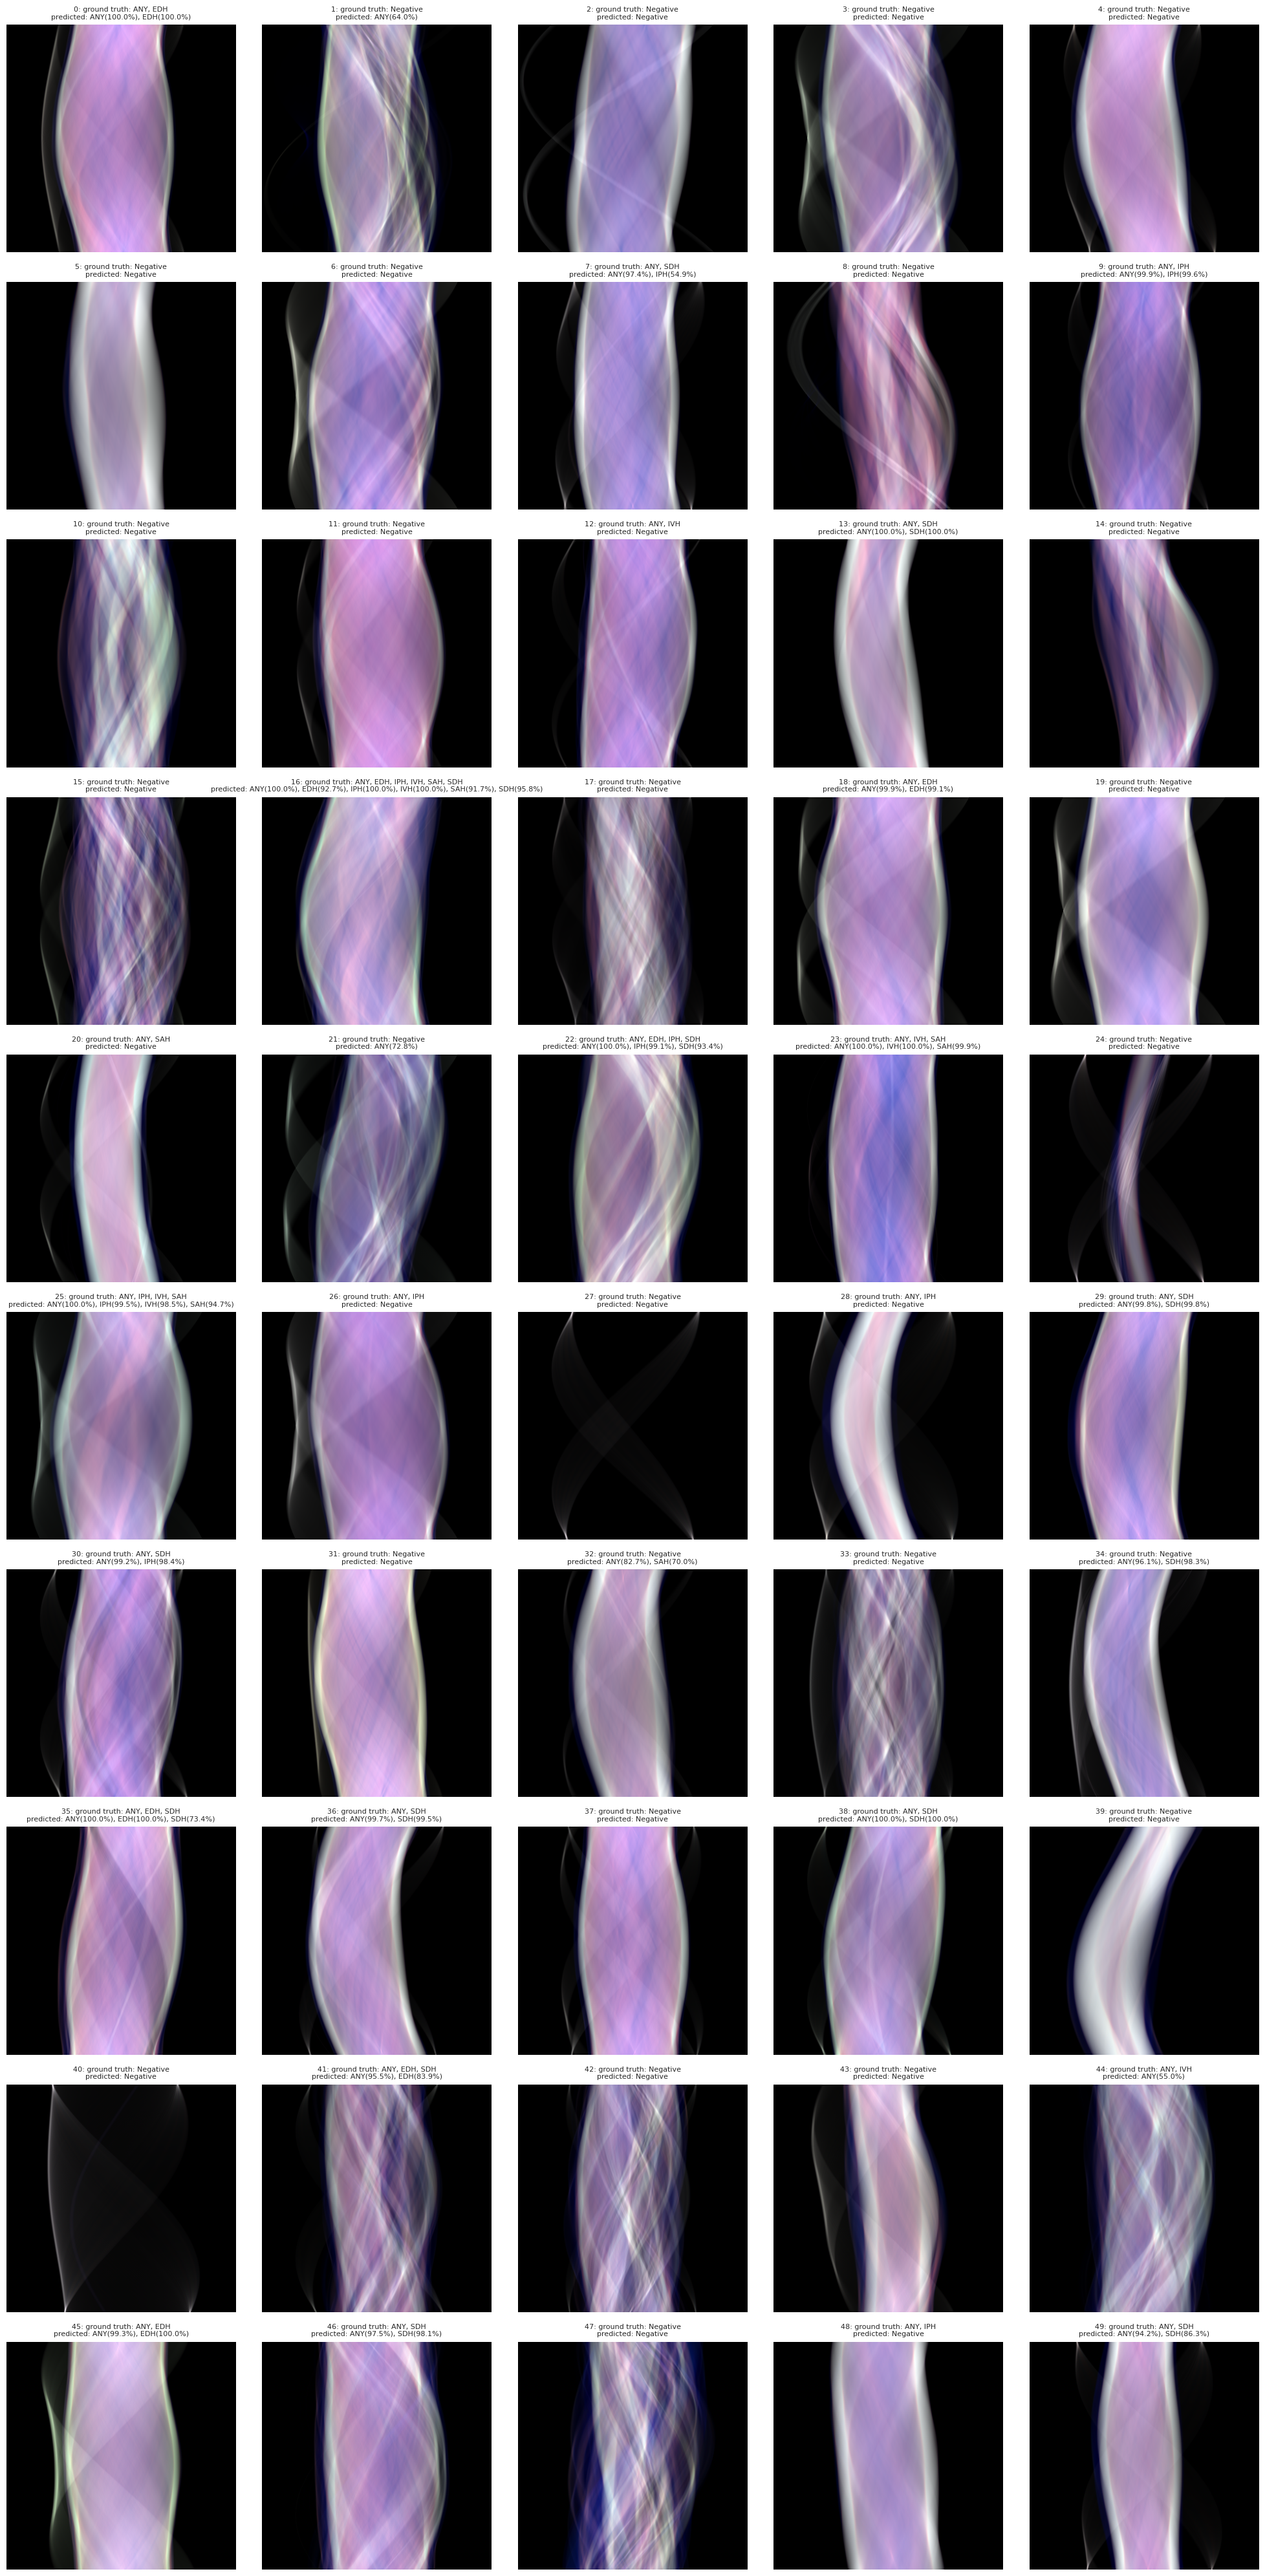

In [37]:
# sanity check
# let's go for first 00th data
y_test_preds = y_preds[0:50]
x_test, y_test = test_data_gen[0]
x_test = x_test[:50].squeeze()
y_test = y_test[:50].squeeze()

labels_map = {
    0: 'ANY', # any
    1: 'EDH', # epidural
    2: 'IPH', # intraparenchymal
    3: 'IVH', # intraventricular
    4: 'SAH', # subarachnoid
    5: 'SDH', # subdural
}

# sanity check
N, M = int(np.ceil(len(y_test_preds)/5)), 5
fig, axes = plt.subplots(N, M, figsize=(M*4,N*4))
for i, ax in enumerate(axes.flat):
    if i < len(y_test_preds):
        ground_truth = ", ".join([labels_map[j] for j in np.where(y_test[i] == 1)[0]])
        ground_truth = str(i) + ': ground truth: ' + (ground_truth if len(ground_truth) > 0 else 'Negative')
        
        
        predicted = ", ".join(['%s(%s)' % (labels_map[j], f'{y_test_preds[i][j]*100:0.01f}%') for j in np.where(y_test_preds[i] >= 0.5)[0]])
        predicted = '\npredicted: ' + (predicted if len(predicted) > 0 else 'Negative')
        # confidient = '\nconfidient: ' + (f'{y_test_preds[i]*100:0.001f}%' if y_test_preds[i] >= 0.5 else f'{(1-y_test_preds[i])*100:0.001f}%')
        ax.imshow(x_test[i], cmap=plt.cm.bone)
        ax.axis('off')
        ax.set_title(ground_truth + predicted)
        ax.title.set_size(8)
    else:
        ax.axis('off')

fig.tight_layout()
fig.show()

In [38]:
class GradCAM:
    def __init__(self, model, last_conv_layer_name):
        """
        Initialize the GradCAM object.

        Args:
        - model: Trained TensorFlow/Keras model.
        - last_conv_layer_name: Name of the last convolutional layer in the model.
        """
        self.model = model
        self.last_conv_layer_name = last_conv_layer_name

        # Create a model that outputs the activations of the last conv layer and predictions
        self.grad_model = tf.keras.models.Model(
            inputs=self.model.input,
            outputs=[
                self.model.get_layer(self.last_conv_layer_name).output,
                self.model.output
            ]
        )

    def compute_heatmap(self, image, class_idx):
        """
        Compute Grad-CAM heatmap for a specific class index.

        Args:
        - image: Preprocessed input image of shape (H, W, C).
        - class_idx: Index of the class to compute the Grad-CAM for.

        Returns:
        - heatmap: Grad-CAM heatmap for the given class index.
        """
        # Add a batch dimension to the image
        image = np.expand_dims(image, axis=0)

        # Record the gradients of the target class output w.r.t. the last conv layer
        with tf.GradientTape() as tape:
            conv_output, predictions = self.grad_model(image)
            target_class_output = predictions[:, class_idx]

        # Compute the gradients of the target class output with respect to conv_output
        grads = tape.gradient(target_class_output, conv_output)

        # Global average pooling of the gradients
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

        # Weight the convolutional layer output with the pooled gradients
        conv_output = conv_output[0]  # Remove batch dimension
        heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_output), axis=-1)

        # Normalize the heatmap to range [0, 1]
        heatmap = np.maximum(heatmap, 0)  # ReLU activation to keep positive values only
        heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1  # Avoid division by zero
        return heatmap

    def overlay_heatmap(self, heatmap, original_image, alpha=0.4, colormap=cv2.COLORMAP_JET):
        """
        Overlay the Grad-CAM heatmap on the original image.

        Args:
        - heatmap: The heatmap to overlay (2D array).
        - original_image: Original image before preprocessing (H, W, C).
        - alpha: Transparency factor for overlaying the heatmap.
        - colormap: OpenCV colormap to apply to the heatmap.

        Returns:
        - overlayed_image: Image with the heatmap overlayed.
        """
        # Resize heatmap to match the original image size
        heatmap_resized = cv2.resize(heatmap, (original_image.shape[1], original_image.shape[0]))
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), colormap)

        # Convert original_image to uint8 if it's not already
        if original_image.dtype != np.uint8:
            original_image = np.uint8(255 * original_image)

        # Blend the heatmap with the original image
        overlayed_image = cv2.addWeighted(original_image, 1 - alpha, heatmap_colored, alpha, 0)
        return overlayed_image

    def generate_heatmaps(self, image, original_image, class_indices, alpha=0.4, colormap=cv2.COLORMAP_JET):
        """
        Generate Grad-CAM heatmaps for multiple class indices.

        Args:
        - image: Preprocessed input image of shape (H, W, C).
        - original_image: Original image before preprocessing (used for overlaying).
        - class_indices: List of class indices to compute heatmaps for.
        - alpha: Transparency factor for overlaying the heatmap.
        - colormap: OpenCV colormap to apply to the heatmap.

        Returns:
        - heatmaps: Dictionary where keys are class indices and values are overlayed images.
        """
        heatmaps = {}
        for class_idx in class_indices:
            heatmap = self.compute_heatmap(image, class_idx)
            overlayed_image = self.overlay_heatmap(heatmap, original_image, alpha, colormap)
            heatmaps[class_idx] = overlayed_image
        return heatmaps


In [75]:
gc_y_pred = y_test_preds[25]
gc_img = x_test[25]
gc_y_pred_idx = np.argwhere(gc_y_pred >= 0.5).squeeze()
gradcam = GradCAM(model.model, last_conv_layer_name="top_conv")
# [original_img, _, _] = gc_img.transpose(2, 0, 1)
# original_img = np.stack((original_img,)*3, axis=-1)
heatmaps = gradcam.generate_heatmaps(gc_img, gc_img, gc_y_pred_idx)

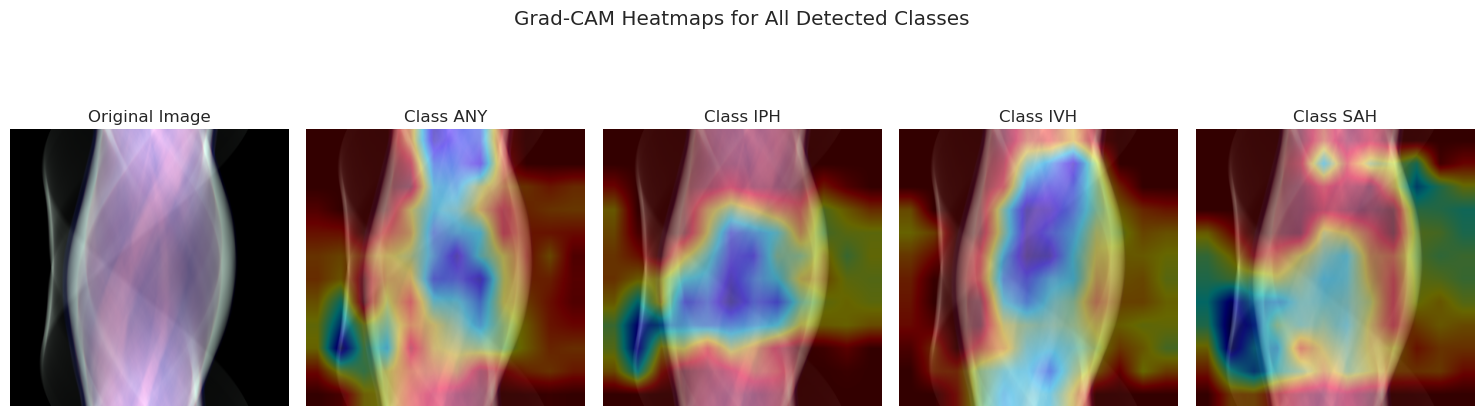

In [77]:
fig, axes = plt.subplots(1, len(gc_y_pred_idx)+1, figsize=(15, 5))
axes[0].imshow(gc_img, cmap=plt.cm.bone)
axes[0].set_title(f"Original Image")
axes[0].axis("off")

for i, class_idx in enumerate(gc_y_pred_idx, start=1):
    ax = axes[i]
    ax.imshow(heatmaps[class_idx])
    ax.set_title(f"Class {labels_map.get(class_idx)}")
    ax.axis("off")
    
plt.suptitle("Grad-CAM Heatmaps for All Detected Classes")
plt.tight_layout()
plt.show()